# Figure S5

Figure S5. Mean seasonal MCS precipitation for (first column) HIST, and percent differences relative to HIST (second column) EoC 4.5, and (third column) EoC 8.5 for (a-c) DJF, (d-f) MAM, (g-i) JJA, and (j-l) SON. For columns 2 and 3, dots denote significant differences in MCS precipitation relative to HIST in that grid based on the Mann-Whitney U test (p < 0.05).

### Read in the data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import xarray as xr

data_dir = "../data"
analysis='mcs_precip'
subset='seasonal'

simulation_names = {'historical': 'HIST', 
                    'future_4p5': 'EoC 4.5', 
                    'delta_future_4p5': '$\Delta$ EoC 4.5',
                    'future_8p5': 'EoC 8.5', 
                    'delta_future_8p5': '$\Delta$ EoC 8.5'}

season_defs = {'DJF': [12, 1, 2], 
               'MAM': [3, 4, 5], 
               'JJA': [6, 7, 8],
               'SON': [9, 10, 11]}
    
season_years = {}
season_means = {}

for sim in simulation_names.keys():

    season_years[sim] = {}
    season_means[sim] = {}
    
    for season in ['DJF', 'MAM', 'SON', 'JJA']:
        
        season_years[sim][season] = {}
        season_means[sim][season] = {}
    
        if sim in ['historical', 'future_4p5', 'future_8p5']:

            ds = xr.open_mfdataset(f"../data/{analysis}/{sim}_{subset}/{analysis}_{sim}_{season}_sums_75km.nc")

            ds = ds.resample(time='AS-OCT').sum('time')

            ds = ds.compute()

            season_years[sim][season] = ds

            ds_mean = ds.mean('time')

            ds_mean = ds_mean.compute()

            season_means[sim][season] = ds_mean
        
        else:

            futr_str = sim.replace("delta_", "")

            hist = season_means['historical'][season]
            futr = season_means[futr_str][season]

            raw_diff = futr - hist

            raw_diff = raw_diff.where(hist >= 1)

            season_means[sim][season] = 100*(raw_diff / hist)

            season_years[sim][season] = None

# Draw the maps

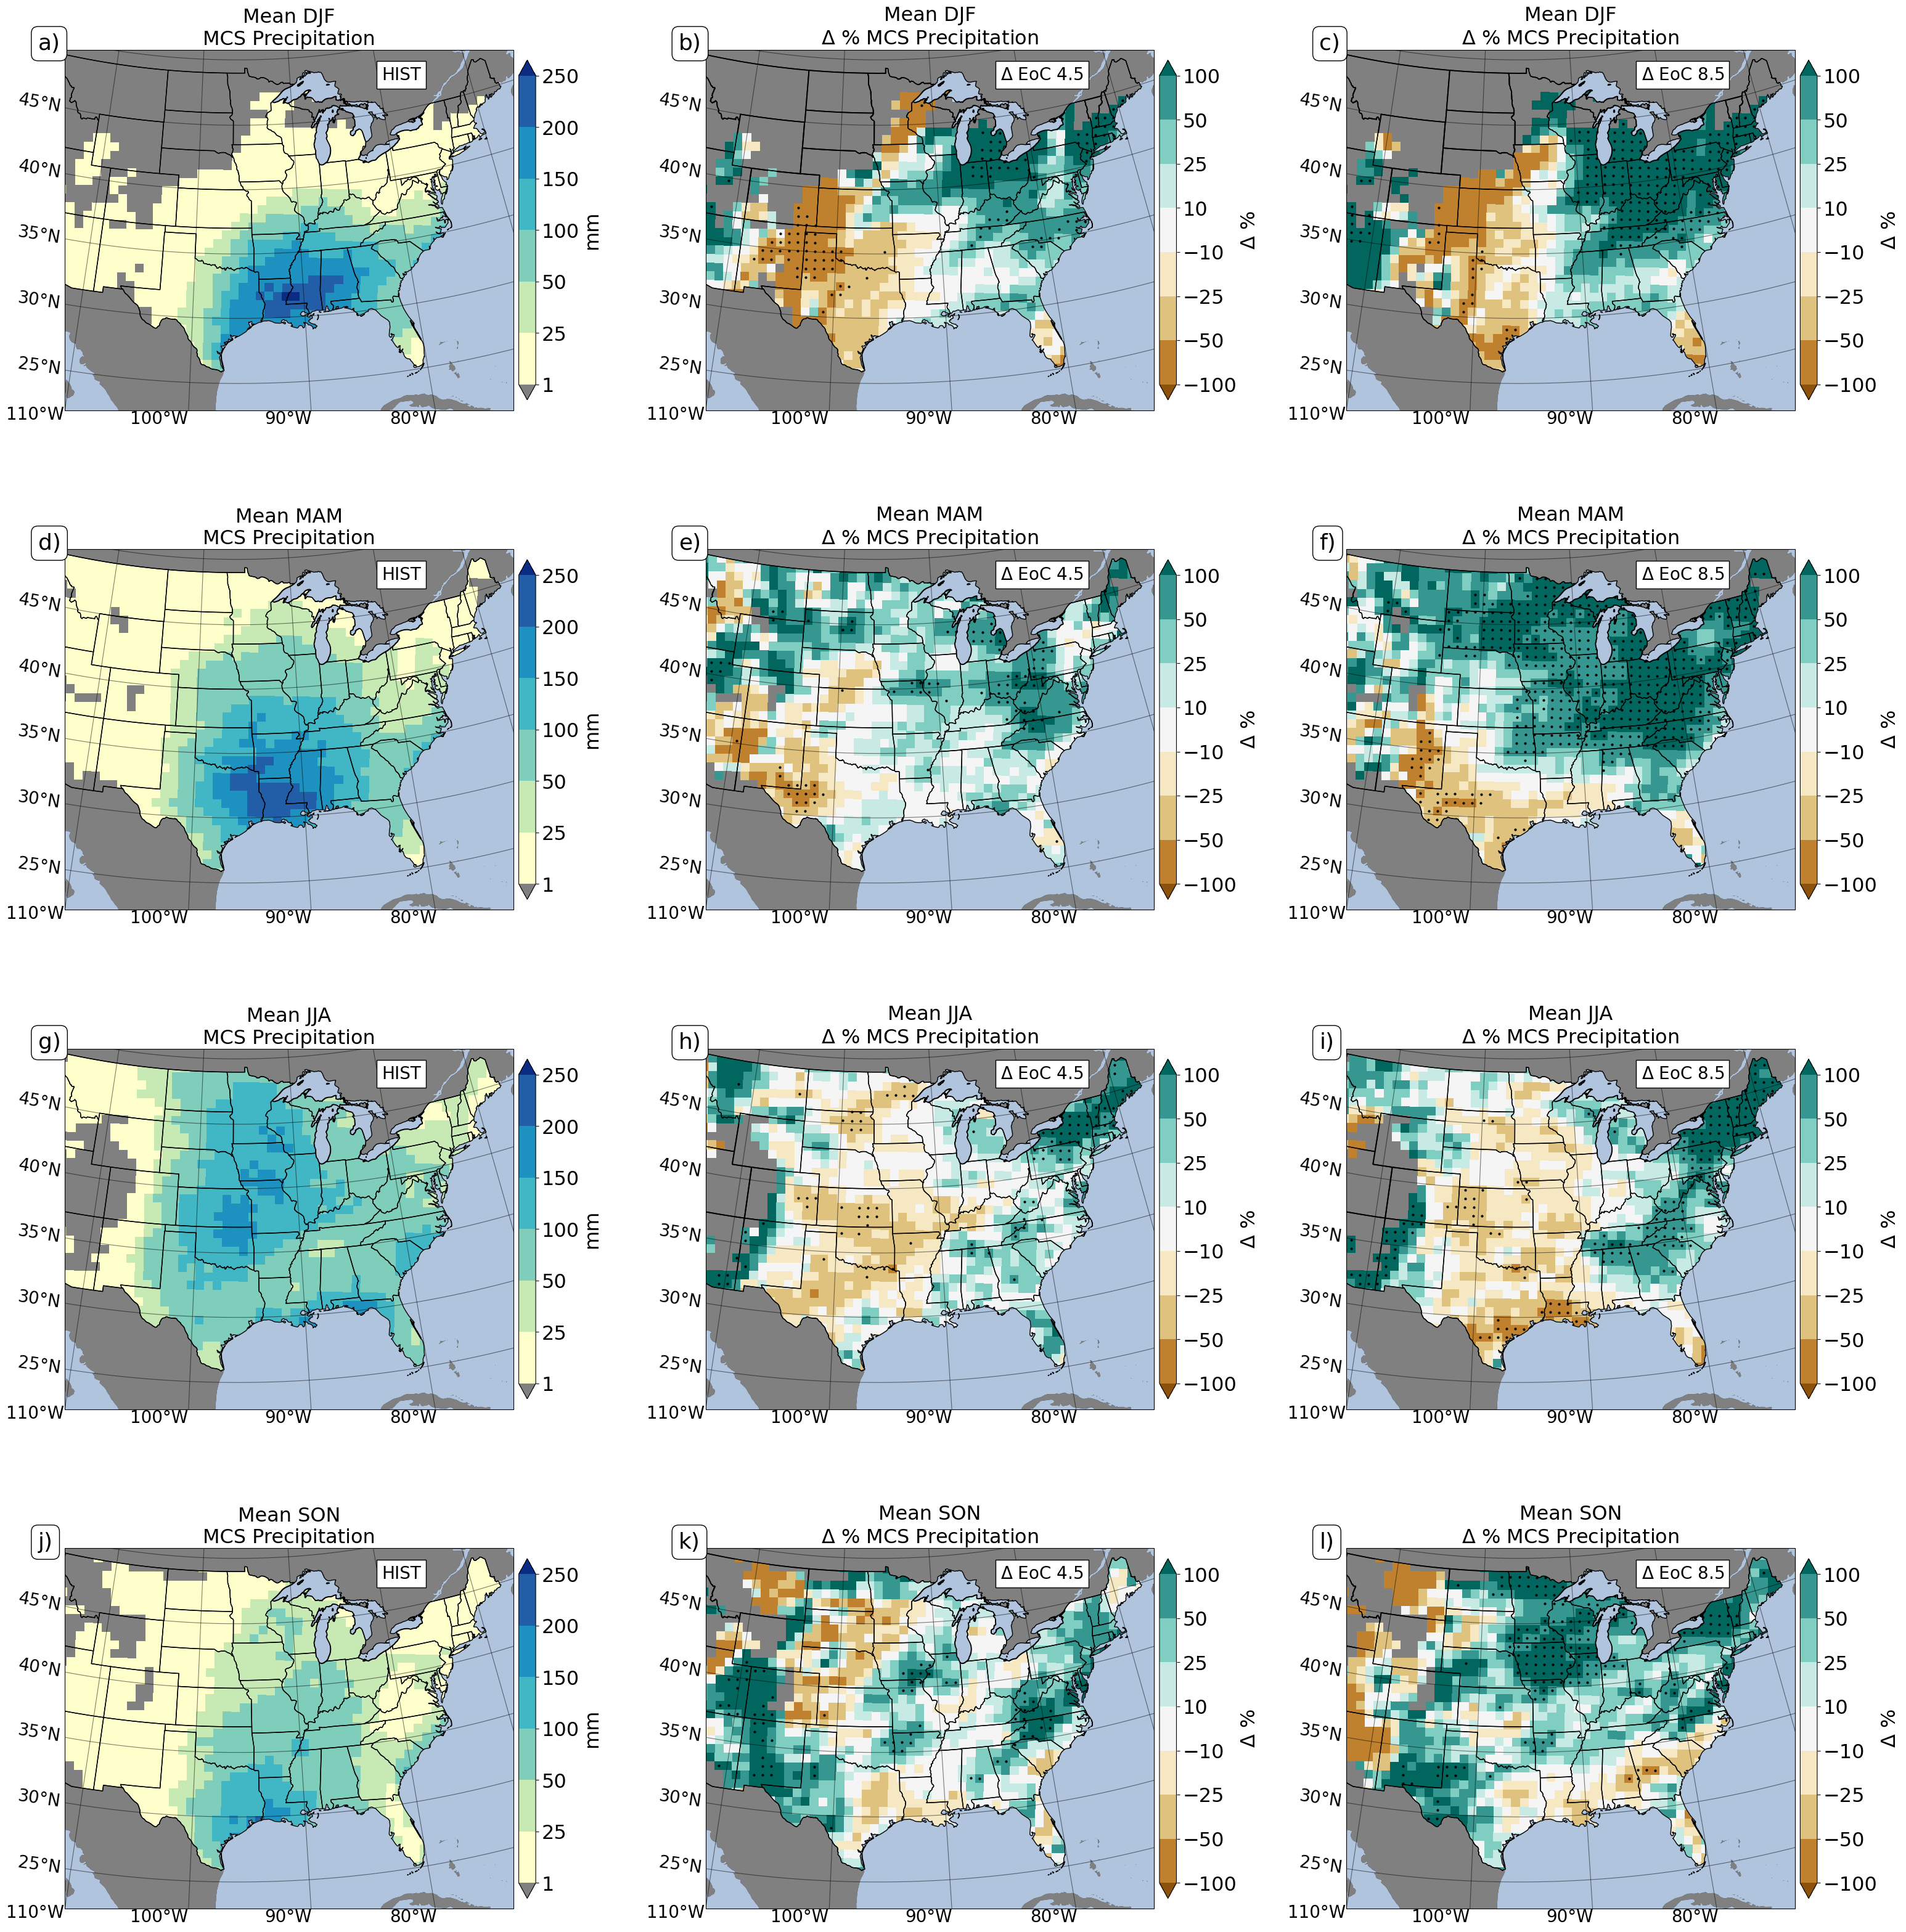

In [3]:
from mapping import setup_map, spec_ax, get_color_dict
from stats import grid_significance
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['axes.labelsize'] = 23

color_info = get_color_dict('S5')

fig = plt.figure(figsize=(38,40))

simulation_dispy = {'historical': 'HIST',
                    'delta_future_4p5': '$\Delta$ EoC 4.5',
                    'delta_future_8p5': '$\Delta$ EoC 8.5'}

for snum, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):

    for ax_pos, (sim_name, sim_abbr) in enumerate(simulation_dispy.items()):

        ax = spec_ax(snum, fig, 4, 3, ax_pos)

        ax = setup_map(label_num=(snum*3) + ax_pos+1, ax=ax)

        ax.annotate(f"{sim_abbr}", (0.75,0.93), 
                    xycoords='axes fraction', ha='center', va='center',
                    fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                    color='k', zorder=25)

        mmp = ax.pcolormesh(season_means[sim_name][season].lon, season_means[sim_name][season].lat, 
                            season_means[sim_name][season]['mcs_mask'],
                            transform=ccrs.PlateCarree(), 
                            cmap=color_info[sim_name]['cmap'], norm=color_info[sim_name]['norm'], zorder=5)

        cbar = plt.colorbar(mmp, ax=ax, shrink=0.85, extend='both', pad=0.01)
    
        if sim_name in ['historical', 'future_4p5', 'future_8p5']:
    
            ax.set_title(f"Mean {season}\nMCS Precipitation")
            
            cbar.set_label(label="mm")
    
        else:
            
            futr_str = sim_name.replace("delta_", "")
            
            ax.set_title(f"Mean {season}\n$\Delta$ % MCS Precipitation")
            
            cbar.set_label(label="$\Delta$ %")

            hist = season_years['historical'][season]['mcs_mask']
            futr = season_years[futr_str][season]['mcs_mask']

            hist = hist.where(season_means['historical'][season]['mcs_mask'] >= 1)
            futr = futr.where(season_means['historical'][season]['mcs_mask'] >= 1)
            
            sig = grid_significance(hist, futr)
    
            pts_sig = np.where(sig < 0.05)
    
            ax.plot(season_means['historical'][season].lon.values[pts_sig],
                    season_means['historical'][season].lat.values[pts_sig],
                    transform=ccrs.PlateCarree(), zorder=5, linestyle='None', 
                    marker='.', color='k', ms=4)
        
        ax.spines['geo'].set_zorder(24)
    
#plt.savefig("Figure_S5.png", dpi=200, bbox_inches='tight')